# COSC 325 Final Project: Credit Card Fraud Analysis
### By "Regularly Scheduled Programming"
**Will Greenwood**&emsp;**Maddie Gross**&emsp;**Cinzia Pacione**&emsp;**Ethan Weathers**

### Contents

- **Introduction and Getting Started**
    - Import Dependencies
    - Read and Clean Data
<p>&nbsp;</p>

- **Exploratory Data Analysis**
    - Subsections (not final yet)
<p>&nbsp;</p>

- **Machine Learning Analysis**
    - Random Forest Implementation
<p>&nbsp;</p>

## Introduction and Getting Started

Intro to this section...

### Import Dependencies

In [3]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Read and Clean Data

Add details later...

In [4]:
# Store csv in a pandas DataFrame
df = pd.read_csv("fraud_data.csv")

# Drop unused columns
drop_columns = []
if drop_columns:
    df.drop(columns=drop_columns, inplace=True)

# Verify there are no null values
null_count = df.isnull().sum()

# Convert selective columns to appropriate data types
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'],
                                             format='%d-%m-%Y %H:%M')
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')

# Add useful columns
df['age'] = 2019 - df['dob'].dt.year


Optional cell to write metadata to a file:

In [5]:
show_metadata = False
if show_metadata:
    with open("metadata.txt", "w") as f:
        from io import StringIO
        
        buffer = StringIO()
        df.info(buf=buffer)
        f.write("DataFrame Info:\n")
        f.write(buffer.getvalue())
        
        f.write("\n\nNumber of unique values per column:\n")
        f.write(df.nunique().to_string())
        
        f.write("\n\nNull values per column:\n")
        f.write(null_count.to_string())

And here are some useful additions/lookups...

In [6]:
# Lookup total number of transactions in entire dataset
total_transactions = len(df)

# Separate DataFrame for just the fraudulent transactions
df_fraud = df[df['is_fraud'] == 1]
fraud_count = len(df_fraud)

# Dictionary to replace snake_case labels with regular text
label_map = {
    'grocery_pos':    'Grocery Pos',
    'gas_transport':  'Gas Transport',
    'shopping_net':   'Shopping Net',
    'shopping_pos':   'Shopping Pos',
    'home':           'Home',
    'kids_pets':      'Kids Pets',
    'personal_care':  'Personal Care',
    'entertainment':  'Entertainment',
    'health_fitness': 'Health Fitness',
    'food_dining':    'Food Dining',
    'misc_pos':       'Misc Pos',
    'misc_net':       'Misc Net',
    'grocery_net':    'Grocery Net',
    'travel':         'Travel'
}

## Exploratory Data Analysis

Intro to this section...

(Will) Pie charts:

**Fraud Index (Percent of Fradulent Transactions) by State**

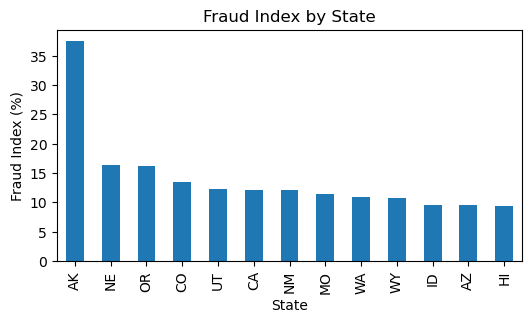

In [7]:
# States
# Step 1: Compute total transactions per state
total_state_tr = df['state'].value_counts()
fraud_state_tr = df[df['is_fraud'] == 1]['state'].value_counts()
fraud_index = (fraud_state_tr / total_state_tr) * 100

fraud_index.sort_values(ascending=False).plot(kind='bar', figsize=(6, 3))
plt.ylabel('Fraud Index (%)')
plt.xlabel('State')
plt.title('Fraud Index by State')
plt.show()


**Fraud by Age**

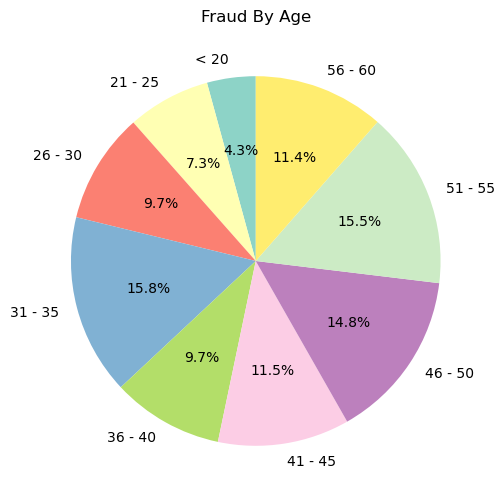

In [8]:
age_brackets = ['< 20',
                '21 - 25', '26 - 30',
                '31 - 35', '36 - 40',
                '41 - 45', '46 - 50',
                '51 - 55', '56 - 60']
age_ranges = [(0, 20),
              (21, 25), (26, 30),
              (31, 35), (36, 40),
              (41, 45), (46, 50),
              (51, 55), (56, 60)]

age_bracket_counts = {}
for bracket, (low, high) in zip(age_brackets, age_ranges):
    age_bracket_counts[bracket] = ((df_fraud['age'] >= low) & (df_fraud['age'] <= high)).sum()

age_fraud_percentage = {
    'Age Bracket': age_bracket_counts.keys(),
    'Percentage': [(count / fraud_count) * 100 for count in age_bracket_counts.values()]
}

age_percentage_df = pd.DataFrame(age_fraud_percentage)

# Plot pie chart
plt.figure(figsize=(8, 6))
age_percentage_df.set_index('Age Bracket')['Percentage'].plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Set3')
plt.ylabel('')
plt.title('Fraud By Age')
plt.show()

What does this tell us? Maybe ML model tageting age will not be useful since the distribution is pretty even.

**Fraud by Category**

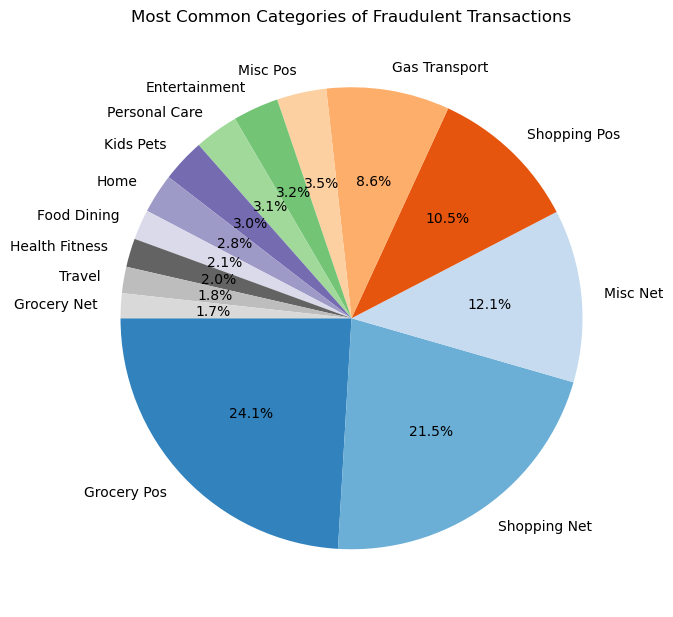

In [9]:
category_counts = df_fraud['category'].value_counts(normalize=True) * 100

# Apply mapping to rename labels
category_counts = category_counts.rename(index=label_map)

plt.figure(figsize=(10, 7.5))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=180, colormap='tab20c')
plt.ylabel('')  # Hide y-axis label
plt.title('Most Common Categories of Fraudulent Transactions')
plt.show()

These are more diverse results. Surely we can do something with this.

Histograms:

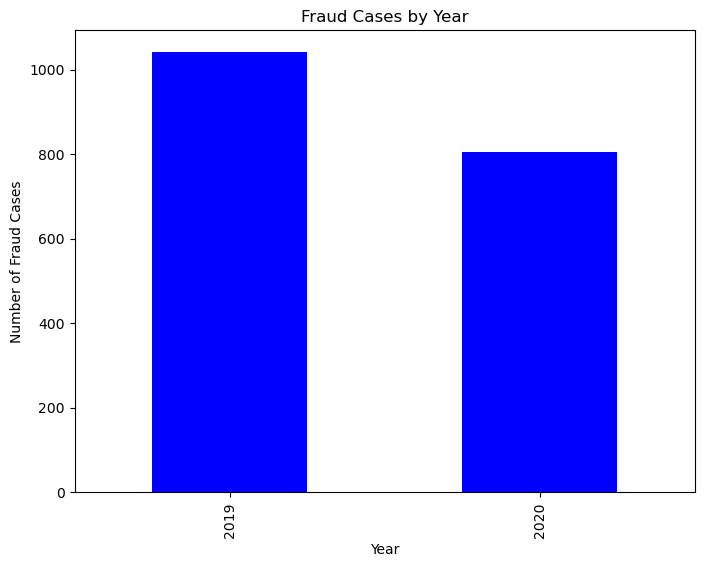

<function matplotlib.pyplot.show(close=None, block=None)>

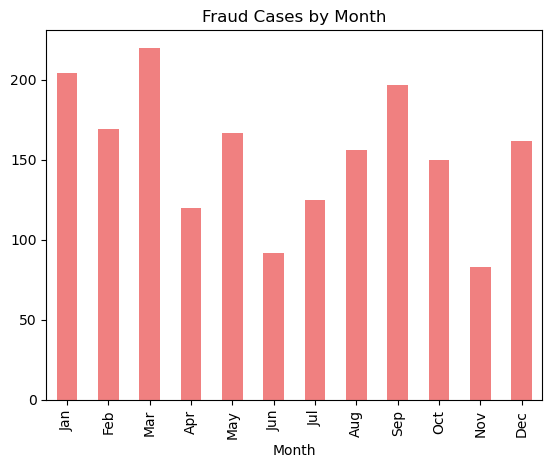

In [10]:
# Ethan
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year
fraud_df = df[df['is_fraud'] == 1]
fraud_by_month = fraud_df['month'].value_counts().sort_index()
fraud_by_year = fraud_df['year'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
fraud_by_year.plot(kind='bar', color='blue')
plt.title("Fraud Cases by Year")
plt.xlabel("Year")
plt.ylabel("Number of Fraud Cases")
plt.show()

fraud_by_month.plot(kind='bar', color='lightcoral')
plt.title("Fraud Cases by Month")
plt.xlabel("Month")
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show

Maps:

In [11]:
# Cinzia

Lists:

In [12]:
# Maddie

## Machine Learning

Intro to this section...

### Baseline Random Forest Implementation by *Robin Rawat*

Intro to this section...

blah blah...using [Rawat's random forest implementation](https://www.kaggle.com/code/robinsinghrawat/credit-card-fraud-analysis).

In [19]:
# random forest baseline model
df_rand_forest = df.copy()

# Adding useful columns
df_rand_forest['trans_date_trans_time'] = pd.to_datetime(df_rand_forest['trans_date_trans_time'], format='%d-%m-%Y %H:%M')

#Extracting hour of transaction
df_rand_forest['transaction_hour'] = df_rand_forest['trans_date_trans_time'].dt.hour

#Dropping irrelevant columns
df_rand_forest = df_rand_forest.drop(columns=
                                     ['trans_date_trans_time',
                                      'dob',
                                      'trans_num',
                                      'merchant',
                                      'state',
                                      'city'])

#Choosing categorical columns to fit into model training
categorical_columns = ['category', 'job']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_rand_forest[col] = le.fit_transform(df_rand_forest[col])
    label_encoders[col] = le

#Converting target variable to numeric
df_rand_forest['is_fraud'] = df_rand_forest['is_fraud'].astype(int)

#Features and target
X = df_rand_forest.drop(columns=['is_fraud'])
y = df_rand_forest['is_fraud']

#Splitting the data 80:20 for training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#Standardizing features using Standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Initializing the model
rf = RandomForestClassifier(random_state=7)

#Setting up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

#Fitting the grid search to the data
grid_search.fit(X_train, y_train)

#Output of the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

best_params = grid_search.best_params_
final_rf = RandomForestClassifier(**best_params, random_state=7)
final_rf.fit(X_train, y_train)

y_pred = final_rf.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.9964520893754708


,precision,recall,f1-score,support
0,0.996080,1.000000,0.998036,2541.00000
1,1.000000,0.971347,0.985465,349.00000
accuracy,0.996540,0.996540,0.996540,0.99654
macro avg,0.998040,0.985673,0.991751,2890.00000
weighted avg,0.996553,0.996540,0.996518,2890.00000


Confusion matrix using optimal hyperparameters...

In [ ]:
# confusion matrix

Precision-Recall Curve

In [ ]:
# precision-recall curve

Conclusions:
- trees